<a href="https://colab.research.google.com/github/sizhky/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter09/Semantic_Segmentation_with_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
if not os.path.exists('dataset1'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip
    !pip install -q torch_snippets pytorch_model_summary

from torch_snippets import *
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torch.nn as nn
import torchvision.models

     |████████████████████████████████| 36.7MB 69kB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 


In [ ]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [ ]:
class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))
        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')
        mask = cv2.resize(mask, (224,224))
        return image, mask
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [ ]:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

2020-10-04 14:04:08.945 | INFO     | torch_snippets.loader:Glob:160 - 367 files found at dataset1/images_prepped_train
2020-10-04 14:04:08.949 | INFO     | torch_snippets.loader:Glob:160 - 101 files found at dataset1/images_prepped_test


In [ ]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [ ]:
def up_conv(in_channels, out_channels):
    return nn.ConvTranspose2d(
        in_channels, out_channels, kernel_size=2, stride=2
    )

In [ ]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [ ]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [ ]:
def train_batch(model, data, optimizer, criterion):
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [ ]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [ ]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 1.256	trn_acc: 0.726	val_loss: 0.911	val_acc: 0.787	(45.39s - 862.38s remaining)
EPOCH: 2.000	trn_loss: 0.731	trn_acc: 0.818	val_loss: 0.711	val_acc: 0.840	(91.85s - 826.63s remaining)
EPOCH: 3.000	trn_loss: 0.598	trn_acc: 0.841	val_loss: 0.614	val_acc: 0.848	(138.93s - 787.28s remaining)
EPOCH: 4.000	trn_loss: 0.518	trn_acc: 0.860	val_loss: 0.522	val_acc: 0.858	(186.05s - 744.19s remaining)
EPOCH: 5.000	trn_loss: 0.478	trn_acc: 0.867	val_loss: 0.508	val_acc: 0.857	(233.17s - 699.52s remaining)
EPOCH: 6.000	trn_loss: 0.429	trn_acc: 0.881	val_loss: 0.526	val_acc: 0.843	(280.32s - 654.09s remaining)
EPOCH: 7.000	trn_loss: 0.442	trn_acc: 0.873	val_loss: 0.486	val_acc: 0.855	(327.40s - 608.02s remaining)
EPOCH: 8.000	trn_loss: 0.391	trn_acc: 0.889	val_loss: 0.466	val_acc: 0.860	(374.56s - 561.83s remaining)
EPOCH: 9.000	trn_loss: 0.375	trn_acc: 0.893	val_loss: 0.425	val_acc: 0.867	(421.67s - 515.38s remaining)
EPOCH: 10.000	trn_loss: 0.346	trn_acc: 0.903	val_loss: 0.

In [ ]:
1

1

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 20/20 [00:00<00:00, 1273.14it/s]


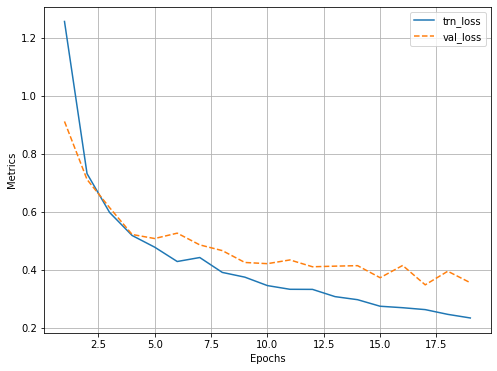

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])

In [ ]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)

2020-10-04 15:02:57.192 | INFO     | torch_snippets.loader:subplots:338 - plotting 3 images in a grid of 1x3 @ (5, 5)


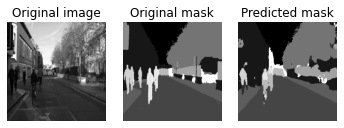

In [ ]:
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0],mask.permute(1,2,0).detach().cpu()[:,:,0]
          ,_mask.permute(1,2,0).detach().cpu()[:,:,0]],nc=3, titles=['Original image','Original mask','Predicted mask'])